# run BRIE

**Detect differential alternative polyadenylation site signal**

In order to identify differential APA signal, we directly exploit BRIE2 which is based on a Bayesian hierarchical model.
If you want to run BRIE2, two files should prepare: one h5ad file including PAS signal count and one tsv file including design matrix information. 

**Prepare h5ad file**

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np

You can find human_intestal_allPAS.h5ad and human_intestinal_gene_exp_scale.h5ad in the figshare (https://doi.org/10.6084/m9.figshare.25902508.v2)

In [2]:
adata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/human_intestal_allPAS.h5ad')
adata

AnnData object with n_obs × n_vars = 14537 × 14025
    obs: 'celltype', 'sample_id', 'organ'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'original_cluster_id', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name'
    obsm: 'X_tsne'

In [3]:
expadata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/human_intestinal_gene_exp_scale.h5ad')
expadata

AnnData object with n_obs × n_vars = 14537 × 62700
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'

Because BRIE requires to input raw count matrix, you should keep the raw count before you do normalization.
Here you can transfer the raw count to X conveniently.

In [4]:
expadata.X=expadata.uns['raw_count']
expadata.X

<14537x62700 sparse matrix of type '<class 'numpy.float32'>'
	with 41145153 stored elements in Compressed Sparse Row format>

In [5]:
expadata.X.toarray()

array([[  0.,   0.,   0., ...,  47.,   0.,   0.],
       [  0.,   0.,   0., ..., 100.,   0.,   1.],
       [  0.,   0.,   0., ...,  64.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 103.,   0.,   0.],
       [  0.,   0.,   0., ..., 117.,   0.,   0.],
       [  0.,   0.,   0., ...,  70.,   0.,   0.]], dtype=float32)

In [6]:
expadata.var.index

Index(['DDX11L2', 'DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2',
       'FAM138A', 'OR4G4P', 'ENSG00000290826', 'OR4G11P',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=62700)

Here, we change the index of expadata. 

In [7]:
expadata.var['gene_name']=expadata.var.index

In [8]:
expadata.var.index=expadata.var['gene_ids']

In [9]:
expadata.var.index

Index(['ENSG00000290825.1', 'ENSG00000223972.6', 'ENSG00000227232.5',
       'ENSG00000278267.1', 'ENSG00000243485.5', 'ENSG00000284332.1',
       'ENSG00000237613.2', 'ENSG00000268020.3', 'ENSG00000290826.1',
       'ENSG00000240361.3',
       ...
       'ENSG00000198886.2', 'ENSG00000210176.1', 'ENSG00000210184.1',
       'ENSG00000210191.1', 'ENSG00000198786.2', 'ENSG00000198695.2',
       'ENSG00000210194.1', 'ENSG00000198727.2', 'ENSG00000210195.2',
       'ENSG00000210196.2'],
      dtype='object', name='gene_ids', length=62700)

In [10]:
expadata.obs_names_make_unique()

Next, we will select genes with two PASs.

In [11]:
genedf=adata.var.copy()
genedf

,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name
chr17_48762233_48762252*ENSG00000170703.16,48762233,48762252,0,-,48762233,48817229,0,-,chr17_-_48762233_48762252*ENSG00000170703.16,chr17,chr17,ENSG00000170703.16,TTLL6
chr10_50626557_50626580*ENSG00000226200.7,50626557,50626580,0,+,50623465,50641451,0,+,chr10_+_50626557_50626580*ENSG00000226200.7,chr10,chr10,ENSG00000226200.7,SGMS1-AS1
chr6_139372255_139372312*ENSG00000164442.11,139372255,139372312,0,-,139371806,139374648,0,-,"chr6_-_139372255_139372288,chr6_-_139372255_13...",chr6,chr6,ENSG00000164442.11,CITED2
chr6_139372947_139373017*ENSG00000164442.11,139372947,139373017,0,-,139371806,139374648,0,-,"chr6_-_139372947_139372996,chr6_-_139372949_13...",chr6,chr6,ENSG00000164442.11,CITED2
chr8_143723932_143723985*ENSG00000180921.7,143723932,143723985,0,-,143723932,143738234,0,-,"chr8_-_143723932_143723953,chr8_-_143723932_14...",chr8,chr8,ENSG00000180921.7,FAM83H
...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr2_96835175_96835195*ENSG00000168763.16,96835175,96835195,0,+,96816244,96835382,0,+,chr2_+_96835175_96835195*ENSG00000168763.16,chr2,chr2,ENSG00000168763.16,CNNM3
chr2_96835357_96835382*ENSG00000168763.16,96835357,96835382,0,+,96816244,96835382,0,+,"chr2_+_96835357_96835381,chr2_+_96835365_96835...",chr2,chr2,ENSG00000168763.16,CNNM3
chr4_151120278_151120332*ENSG00000109686.20,151120278,151120332,0,-,151102750,151325605,0,-,"chr4_-_151120278_151120316,chr4_-_151120278_15...",chr4,chr4,ENSG00000109686.20,SH3D19
chr4_151121365_151121392*ENSG00000109686.20,151121365,151121392,0,-,151102750,151325605,0,-,"chr4_-_151121365_151121392,chr4_-_151121366_15...",chr4,chr4,ENSG00000109686.20,SH3D19


In [12]:
genedf.reset_index(inplace=True)
genedf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name
0,chr17_48762233_48762252*ENSG00000170703.16,48762233,48762252,0,-,48762233,48817229,0,-,chr17_-_48762233_48762252*ENSG00000170703.16,chr17,chr17,ENSG00000170703.16,TTLL6
1,chr10_50626557_50626580*ENSG00000226200.7,50626557,50626580,0,+,50623465,50641451,0,+,chr10_+_50626557_50626580*ENSG00000226200.7,chr10,chr10,ENSG00000226200.7,SGMS1-AS1
2,chr6_139372255_139372312*ENSG00000164442.11,139372255,139372312,0,-,139371806,139374648,0,-,"chr6_-_139372255_139372288,chr6_-_139372255_13...",chr6,chr6,ENSG00000164442.11,CITED2
3,chr6_139372947_139373017*ENSG00000164442.11,139372947,139373017,0,-,139371806,139374648,0,-,"chr6_-_139372947_139372996,chr6_-_139372949_13...",chr6,chr6,ENSG00000164442.11,CITED2
4,chr8_143723932_143723985*ENSG00000180921.7,143723932,143723985,0,-,143723932,143738234,0,-,"chr8_-_143723932_143723953,chr8_-_143723932_14...",chr8,chr8,ENSG00000180921.7,FAM83H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14020,chr2_96835175_96835195*ENSG00000168763.16,96835175,96835195,0,+,96816244,96835382,0,+,chr2_+_96835175_96835195*ENSG00000168763.16,chr2,chr2,ENSG00000168763.16,CNNM3
14021,chr2_96835357_96835382*ENSG00000168763.16,96835357,96835382,0,+,96816244,96835382,0,+,"chr2_+_96835357_96835381,chr2_+_96835365_96835...",chr2,chr2,ENSG00000168763.16,CNNM3
14022,chr4_151120278_151120332*ENSG00000109686.20,151120278,151120332,0,-,151102750,151325605,0,-,"chr4_-_151120278_151120316,chr4_-_151120278_15...",chr4,chr4,ENSG00000109686.20,SH3D19
14023,chr4_151121365_151121392*ENSG00000109686.20,151121365,151121392,0,-,151102750,151325605,0,-,"chr4_-_151121365_151121392,chr4_-_151121366_15...",chr4,chr4,ENSG00000109686.20,SH3D19


In [13]:
keepgenedf=genedf[genedf.duplicated('gene_id',keep=False)]
keepgenedf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name
2,chr6_139372255_139372312*ENSG00000164442.11,139372255,139372312,0,-,139371806,139374648,0,-,"chr6_-_139372255_139372288,chr6_-_139372255_13...",chr6,chr6,ENSG00000164442.11,CITED2
3,chr6_139372947_139373017*ENSG00000164442.11,139372947,139373017,0,-,139371806,139374648,0,-,"chr6_-_139372947_139372996,chr6_-_139372949_13...",chr6,chr6,ENSG00000164442.11,CITED2
7,chr4_69721166_69721208*ENSG00000173597.9,69721166,69721208,0,-,69721166,69787961,0,-,"chr4_-_69721166_69721194,chr4_-_69721166_69721...",chr4,chr4,ENSG00000173597.9,SULT1B1
8,chr4_69726841_69726860*ENSG00000173597.9,69726841,69726860,0,-,69721166,69787961,0,-,"chr4_-_69726841_69726855,chr4_-_69726841_69726...",chr4,chr4,ENSG00000173597.9,SULT1B1
9,chr4_69726960_69727014*ENSG00000173597.9,69726960,69727014,0,-,69721166,69787961,0,-,"chr4_-_69726960_69726999,chr4_-_69726961_69726...",chr4,chr4,ENSG00000173597.9,SULT1B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14019,chr2_96833523_96833579*ENSG00000168763.16,96833523,96833579,0,+,96816244,96835382,0,+,"chr2_+_96833523_96833577,chr2_+_96833527_96833...",chr2,chr2,ENSG00000168763.16,CNNM3
14020,chr2_96835175_96835195*ENSG00000168763.16,96835175,96835195,0,+,96816244,96835382,0,+,chr2_+_96835175_96835195*ENSG00000168763.16,chr2,chr2,ENSG00000168763.16,CNNM3
14021,chr2_96835357_96835382*ENSG00000168763.16,96835357,96835382,0,+,96816244,96835382,0,+,"chr2_+_96835357_96835381,chr2_+_96835365_96835...",chr2,chr2,ENSG00000168763.16,CNNM3
14022,chr4_151120278_151120332*ENSG00000109686.20,151120278,151120332,0,-,151102750,151325605,0,-,"chr4_-_151120278_151120316,chr4_-_151120278_15...",chr4,chr4,ENSG00000109686.20,SH3D19


If the PAS signal located in the positive strand, then we define the cluster_end as the PAS.
If the PAS singal located in the negative strand, then we define the cluster_start as the PAS.

In [17]:
keepgenedf['PAS']=np.where(keepgenedf['cluster_strand']=='+',keepgenedf['cluster_end'],keepgenedf['cluster_start'])
keepgenedf

/tmp/ipykernel_102890/2080422649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keepgenedf['PAS']=np.where(keepgenedf['cluster_strand']=='+',keepgenedf['cluster_end'],keepgenedf['cluster_start'])


,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
2,chr6_139372255_139372312*ENSG00000164442.11,139372255,139372312,0,-,139371806,139374648,0,-,"chr6_-_139372255_139372288,chr6_-_139372255_13...",chr6,chr6,ENSG00000164442.11,CITED2,139372255
3,chr6_139372947_139373017*ENSG00000164442.11,139372947,139373017,0,-,139371806,139374648,0,-,"chr6_-_139372947_139372996,chr6_-_139372949_13...",chr6,chr6,ENSG00000164442.11,CITED2,139372947
7,chr4_69721166_69721208*ENSG00000173597.9,69721166,69721208,0,-,69721166,69787961,0,-,"chr4_-_69721166_69721194,chr4_-_69721166_69721...",chr4,chr4,ENSG00000173597.9,SULT1B1,69721166
8,chr4_69726841_69726860*ENSG00000173597.9,69726841,69726860,0,-,69721166,69787961,0,-,"chr4_-_69726841_69726855,chr4_-_69726841_69726...",chr4,chr4,ENSG00000173597.9,SULT1B1,69726841
9,chr4_69726960_69727014*ENSG00000173597.9,69726960,69727014,0,-,69721166,69787961,0,-,"chr4_-_69726960_69726999,chr4_-_69726961_69726...",chr4,chr4,ENSG00000173597.9,SULT1B1,69726960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14019,chr2_96833523_96833579*ENSG00000168763.16,96833523,96833579,0,+,96816244,96835382,0,+,"chr2_+_96833523_96833577,chr2_+_96833527_96833...",chr2,chr2,ENSG00000168763.16,CNNM3,96833579
14020,chr2_96835175_96835195*ENSG00000168763.16,96835175,96835195,0,+,96816244,96835382,0,+,chr2_+_96835175_96835195*ENSG00000168763.16,chr2,chr2,ENSG00000168763.16,CNNM3,96835195
14021,chr2_96835357_96835382*ENSG00000168763.16,96835357,96835382,0,+,96816244,96835382,0,+,"chr2_+_96835357_96835381,chr2_+_96835365_96835...",chr2,chr2,ENSG00000168763.16,CNNM3,96835382
14022,chr4_151120278_151120332*ENSG00000109686.20,151120278,151120332,0,-,151102750,151325605,0,-,"chr4_-_151120278_151120316,chr4_-_151120278_15...",chr4,chr4,ENSG00000109686.20,SH3D19,151120278


In [18]:
positivedf=keepgenedf[keepgenedf['cluster_strand']=='+']
positivedf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
16,chr1_224159472_224159560*ENSG00000143756.12,224159472,224159560,0,+,224114110,224162047,0,+,"chr1_+_224159472_224159560,chr1_+_224159488_22...",chr1,chr1,ENSG00000143756.12,FBXO28,224159560
17,chr1_224162032_224162047*ENSG00000143756.12,224162032,224162047,0,+,224114110,224162047,0,+,"chr1_+_224162032_224162047,chr1_+_224162032_22...",chr1,chr1,ENSG00000143756.12,FBXO28,224162047
22,chr9_69248930_69248989*ENSG00000119139.21,69248930,69248989,0,+,69121263,69274615,0,+,"chr9_+_69248930_69248970,chr9_+_69248933_69248...",chr9,chr9,ENSG00000119139.21,TJP2,69248989
23,chr9_69255177_69255205*ENSG00000119139.21,69255177,69255205,0,+,69121263,69274615,0,+,"chr9_+_69255177_69255203,chr9_+_69255177_69255...",chr9,chr9,ENSG00000119139.21,TJP2,69255205
29,chr22_31277340_31277418*ENSG00000182541.18,31277340,31277418,0,+,31212238,31280080,0,+,"chr22_+_31277340_31277418,chr22_+_31277343_312...",chr22,chr22,ENSG00000182541.18,LIMK2,31277418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14010,chr4_158906760_158906806*ENSG00000052795.13,158906760,158906806,0,+,158769025,158908050,0,+,"chr4_+_158906760_158906799,chr4_+_158906763_15...",chr4,chr4,ENSG00000052795.13,FNIP2,158906806
14011,chr4_158908008_158908050*ENSG00000052795.13,158908008,158908050,0,+,158769025,158908050,0,+,"chr4_+_158908008_158908050,chr4_+_158908008_15...",chr4,chr4,ENSG00000052795.13,FNIP2,158908050
14019,chr2_96833523_96833579*ENSG00000168763.16,96833523,96833579,0,+,96816244,96835382,0,+,"chr2_+_96833523_96833577,chr2_+_96833527_96833...",chr2,chr2,ENSG00000168763.16,CNNM3,96833579
14020,chr2_96835175_96835195*ENSG00000168763.16,96835175,96835195,0,+,96816244,96835382,0,+,chr2_+_96835175_96835195*ENSG00000168763.16,chr2,chr2,ENSG00000168763.16,CNNM3,96835195


In [19]:
positivedf.sort_values(['gene_id','PAS'],inplace=True)
positivedf

/tmp/ipykernel_102890/899284162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positivedf.sort_values(['gene_id','PAS'],inplace=True)


,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
9107,chr7_117627883_117627910*ENSG00000001626.18,117627883,117627910,0,+,117287119,117715971,0,+,chr7_+_117627883_117627910*ENSG00000001626.18,chr7,chr7,ENSG00000001626.18,CFTR,117627910
9108,chr7_117668613_117668665*ENSG00000001626.18,117668613,117668665,0,+,117287119,117715971,0,+,"chr7_+_117668613_117668665,chr7_+_117668616_11...",chr7,chr7,ENSG00000001626.18,CFTR,117668665
11674,chr7_92399310_92399333*ENSG00000001629.10,92399310,92399333,0,+,92245973,92401383,0,+,chr7_+_92399310_92399333*ENSG00000001629.10,chr7,chr7,ENSG00000001629.10,ANKIB1,92399333
11675,chr7_92401340_92401383*ENSG00000001629.10,92401340,92401383,0,+,92245973,92401383,0,+,"chr7_+_92401340_92401383,chr7_+_92401346_92401...",chr7,chr7,ENSG00000001629.10,ANKIB1,92401383
4404,chr2_201141559_201141602*ENSG00000003402.21,201141559,201141602,0,+,201116153,201176687,0,+,"chr2_+_201141559_201141602,chr2_+_201141561_20...",chr2,chr2,ENSG00000003402.21,CFLAR,201141602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11980,chr11_119939953_119939998*ENSG00000288047.3,119939953,119939998,0,+,119892699,119939998,0,+,"chr11_+_119939953_119939998,chr11_+_119939957_...",chr11,chr11,ENSG00000288047.3,ENSG00000288047,119939998
8405,chr9_131498122_131498231*ENSG00000288701.1,131498122,131498231,0,+,131373635,131500197,0,+,"chr9_+_131498122_131498160,chr9_+_131498123_13...",chr9,chr9,ENSG00000288701.1,PRRC2B,131498231
8406,chr9_131500136_131500197*ENSG00000288701.1,131500136,131500197,0,+,131373635,131500197,0,+,"chr9_+_131500136_131500197,chr9_+_131500139_13...",chr9,chr9,ENSG00000288701.1,PRRC2B,131500197
11622,chr1_149844768_149844805*ENSG00000290791.1,149844768,149844805,0,+,149842874,149846486,0,+,"chr1_+_149844768_149844805,chr1_+_149844785_14...",chr1,chr1,ENSG00000290791.1,ENSG00000290791,149844805


We defined the furthest upstream PAS as the proximal PAS and furthest downstream PAS as the distal PAS.

In [21]:
positive_proxmaldf=positivedf.groupby(['gene_id']).head(n=1)
positive_proxmaldf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
9107,chr7_117627883_117627910*ENSG00000001626.18,117627883,117627910,0,+,117287119,117715971,0,+,chr7_+_117627883_117627910*ENSG00000001626.18,chr7,chr7,ENSG00000001626.18,CFTR,117627910
11674,chr7_92399310_92399333*ENSG00000001629.10,92399310,92399333,0,+,92245973,92401383,0,+,chr7_+_92399310_92399333*ENSG00000001629.10,chr7,chr7,ENSG00000001629.10,ANKIB1,92399333
4404,chr2_201141559_201141602*ENSG00000003402.21,201141559,201141602,0,+,201116153,201176687,0,+,"chr2_+_201141559_201141602,chr2_+_201141561_20...",chr2,chr2,ENSG00000003402.21,CFLAR,201141602
277,chr12_2803327_2803374*ENSG00000004478.8,2803327,2803374,0,+,2794969,2805423,0,+,"chr12_+_2803327_2803369,chr12_+_2803328_280337...",chr12,chr12,ENSG00000004478.8,FKBP4,2803374
6618,chrX_11121812_11121889*ENSG00000004961.15,11121812,11121889,0,+,11111300,11123086,0,+,"chrX_+_11121812_11121887,chrX_+_11121815_11121...",chrX,chrX,ENSG00000004961.15,HCCS,11121889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,chr9_37087786_37087847*ENSG00000281649.3,37087786,37087847,0,+,37079644,37090928,0,+,"chr9_+_37087786_37087836,chr9_+_37087786_37087...",chr9,chr9,ENSG00000281649.3,EBLN3P,37087847
13822,chr7_150410917_150410984*ENSG00000284691.1,150410917,150410984,0,+,150400701,150412470,0,+,"chr7_+_150410917_150410983,chr7_+_150410918_15...",chr7,chr7,ENSG00000284691.1,ENSG00000284691,150410984
11979,chr11_119919964_119920003*ENSG00000288047.3,119919964,119920003,0,+,119892699,119939998,0,+,"chr11_+_119919964_119920003,chr11_+_119919975_...",chr11,chr11,ENSG00000288047.3,ENSG00000288047,119920003
8405,chr9_131498122_131498231*ENSG00000288701.1,131498122,131498231,0,+,131373635,131500197,0,+,"chr9_+_131498122_131498160,chr9_+_131498123_13...",chr9,chr9,ENSG00000288701.1,PRRC2B,131498231


In [22]:
positive_distaldf=positivedf.groupby(['gene_id']).tail(n=1)
positive_distaldf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
9108,chr7_117668613_117668665*ENSG00000001626.18,117668613,117668665,0,+,117287119,117715971,0,+,"chr7_+_117668613_117668665,chr7_+_117668616_11...",chr7,chr7,ENSG00000001626.18,CFTR,117668665
11675,chr7_92401340_92401383*ENSG00000001629.10,92401340,92401383,0,+,92245973,92401383,0,+,"chr7_+_92401340_92401383,chr7_+_92401346_92401...",chr7,chr7,ENSG00000001629.10,ANKIB1,92401383
4407,chr2_201171638_201171754*ENSG00000003402.21,201171638,201171754,0,+,201116153,201176687,0,+,"chr2_+_201171638_201171736,chr2_+_201171647_20...",chr2,chr2,ENSG00000003402.21,CFLAR,201171754
278,chr12_2803890_2803966*ENSG00000004478.8,2803890,2803966,0,+,2794969,2805423,0,+,"chr12_+_2803890_2803959,chr12_+_2803893_280396...",chr12,chr12,ENSG00000004478.8,FKBP4,2803966
6619,chrX_11123040_11123086*ENSG00000004961.15,11123040,11123086,0,+,11111300,11123086,0,+,"chrX_+_11123040_11123082,chrX_+_11123043_11123...",chrX,chrX,ENSG00000004961.15,HCCS,11123086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,chr9_37090352_37090406*ENSG00000281649.3,37090352,37090406,0,+,37079644,37090928,0,+,"chr9_+_37090352_37090396,chr9_+_37090353_37090...",chr9,chr9,ENSG00000281649.3,EBLN3P,37090406
13823,chr7_150412434_150412470*ENSG00000284691.1,150412434,150412470,0,+,150400701,150412470,0,+,chr7_+_150412434_150412470*ENSG00000284691.1,chr7,chr7,ENSG00000284691.1,ENSG00000284691,150412470
11980,chr11_119939953_119939998*ENSG00000288047.3,119939953,119939998,0,+,119892699,119939998,0,+,"chr11_+_119939953_119939998,chr11_+_119939957_...",chr11,chr11,ENSG00000288047.3,ENSG00000288047,119939998
8406,chr9_131500136_131500197*ENSG00000288701.1,131500136,131500197,0,+,131373635,131500197,0,+,"chr9_+_131500136_131500197,chr9_+_131500139_13...",chr9,chr9,ENSG00000288701.1,PRRC2B,131500197


In [26]:
negativedf=keepgenedf[keepgenedf['cluster_strand']=='-']
negativedf

negativedf.sort_values(['gene_id','PAS'],inplace=True)
negativedf

negative_promdf=negativedf.groupby(['gene_id']).tail(n=1)
negative_promdf

negative_distaldf=negativedf.groupby(['gene_id']).head(n=1)
negative_distaldf

/tmp/ipykernel_102890/1163048929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negativedf.sort_values(['gene_id','PAS'],inplace=True)


,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
957,chrX_100628705_100628755*ENSG00000000003.16,100628705,100628755,0,-,100627107,100639991,0,-,"chrX_-_100628705_100628753,chrX_-_100628714_10...",chrX,chrX,ENSG00000000003.16,TSPAN6,100628705
2950,chr1_169851007_169851106*ENSG00000000457.14,169851007,169851106,0,-,169849630,169894267,0,-,"chr1_-_169851007_169851103,chr1_-_169851011_16...",chr1,chr1,ENSG00000000457.14,SCYL3,169851007
2330,chr17_28347176_28347224*ENSG00000004142.12,28347176,28347224,0,-,28346632,28357527,0,-,"chr17_-_28347176_28347201,chr17_-_28347176_283...",chr17,chr17,ENSG00000004142.12,POLDIP2,28347176
5297,chr1_33008874_33008931*ENSG00000004455.18,33008874,33008931,0,-,33007985,33080996,0,-,"chr1_-_33008874_33008918,chr1_-_33008877_33008...",chr1,chr1,ENSG00000004455.18,AK2,33008874
3911,chr7_95583498_95583548*ENSG00000004799.8,95583498,95583548,0,-,95583498,95596516,0,-,"chr7_-_95583498_95583517,chr7_-_95583498_95583...",chr7,chr7,ENSG00000004799.8,PDK4,95583498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8272,chr16_75501692_75501767*ENSG00000291051.1,75501692,75501767,0,-,75501692,75517335,0,-,"chr16_-_75501692_75501714,chr16_-_75501692_755...",chr16,chr16,ENSG00000291051.1,ENSG00000291051,75501692
6825,chr5_1628513_1628550*ENSG00000291079.1,1628513,1628550,0,-,1598919,1634014,0,-,"chr5_-_1628513_1628532,chr5_-_1628515_1628550,...",chr5,chr5,ENSG00000291079.1,ENSG00000291079,1628513
4747,chr7_66553532_66553614*ENSG00000291136.1,66553532,66553614,0,-,66526087,66592397,0,-,"chr7_-_66553532_66553614,chr7_-_66553564_66553...",chr7,chr7,ENSG00000291136.1,ENSG00000291136,66553532
9864,chr7_100320908_100320958*ENSG00000291178.1,100320908,100320958,0,-,100300019,100336307,0,-,"chr7_-_100320908_100320939,chr7_-_100320911_10...",chr7,chr7,ENSG00000291178.1,ENSG00000291178,100320908


In [27]:
promialdf=pd.concat([positive_proxmaldf,negative_promdf],axis=0)
promialdf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
9107,chr7_117627883_117627910*ENSG00000001626.18,117627883,117627910,0,+,117287119,117715971,0,+,chr7_+_117627883_117627910*ENSG00000001626.18,chr7,chr7,ENSG00000001626.18,CFTR,117627910
11674,chr7_92399310_92399333*ENSG00000001629.10,92399310,92399333,0,+,92245973,92401383,0,+,chr7_+_92399310_92399333*ENSG00000001629.10,chr7,chr7,ENSG00000001629.10,ANKIB1,92399333
4404,chr2_201141559_201141602*ENSG00000003402.21,201141559,201141602,0,+,201116153,201176687,0,+,"chr2_+_201141559_201141602,chr2_+_201141561_20...",chr2,chr2,ENSG00000003402.21,CFLAR,201141602
277,chr12_2803327_2803374*ENSG00000004478.8,2803327,2803374,0,+,2794969,2805423,0,+,"chr12_+_2803327_2803369,chr12_+_2803328_280337...",chr12,chr12,ENSG00000004478.8,FKBP4,2803374
6618,chrX_11121812_11121889*ENSG00000004961.15,11121812,11121889,0,+,11111300,11123086,0,+,"chrX_+_11121812_11121887,chrX_+_11121815_11121...",chrX,chrX,ENSG00000004961.15,HCCS,11121889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273,chr16_75504657_75504679*ENSG00000291051.1,75504657,75504679,0,-,75501692,75517335,0,-,chr16_-_75504657_75504679*ENSG00000291051.1,chr16,chr16,ENSG00000291051.1,ENSG00000291051,75504657
6826,chr5_1628685_1628721*ENSG00000291079.1,1628685,1628721,0,-,1598919,1634014,0,-,"chr5_-_1628685_1628710,chr5_-_1628688_1628710,...",chr5,chr5,ENSG00000291079.1,ENSG00000291079,1628685
4748,chr7_66584030_66584123*ENSG00000291136.1,66584030,66584123,0,-,66526087,66592397,0,-,chr7_-_66584030_66584123*ENSG00000291136.1,chr7,chr7,ENSG00000291136.1,ENSG00000291136,66584030
9865,chr7_100329940_100330026*ENSG00000291178.1,100329940,100330026,0,-,100300019,100336307,0,-,"chr7_-_100329940_100330026,chr7_-_100329978_10...",chr7,chr7,ENSG00000291178.1,ENSG00000291178,100329940


In [28]:
distaldf=pd.concat([positive_distaldf,negative_distaldf],axis=0)
distaldf

,index,cluster_start,cluster_end,cluster_score,cluster_strand,gene_start,gene_end,gene_score,gene_strand,original_cluster_id,cluster_chr,gene_chr,gene_id,gene_name,PAS
9108,chr7_117668613_117668665*ENSG00000001626.18,117668613,117668665,0,+,117287119,117715971,0,+,"chr7_+_117668613_117668665,chr7_+_117668616_11...",chr7,chr7,ENSG00000001626.18,CFTR,117668665
11675,chr7_92401340_92401383*ENSG00000001629.10,92401340,92401383,0,+,92245973,92401383,0,+,"chr7_+_92401340_92401383,chr7_+_92401346_92401...",chr7,chr7,ENSG00000001629.10,ANKIB1,92401383
4407,chr2_201171638_201171754*ENSG00000003402.21,201171638,201171754,0,+,201116153,201176687,0,+,"chr2_+_201171638_201171736,chr2_+_201171647_20...",chr2,chr2,ENSG00000003402.21,CFLAR,201171754
278,chr12_2803890_2803966*ENSG00000004478.8,2803890,2803966,0,+,2794969,2805423,0,+,"chr12_+_2803890_2803959,chr12_+_2803893_280396...",chr12,chr12,ENSG00000004478.8,FKBP4,2803966
6619,chrX_11123040_11123086*ENSG00000004961.15,11123040,11123086,0,+,11111300,11123086,0,+,"chrX_+_11123040_11123082,chrX_+_11123043_11123...",chrX,chrX,ENSG00000004961.15,HCCS,11123086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8272,chr16_75501692_75501767*ENSG00000291051.1,75501692,75501767,0,-,75501692,75517335,0,-,"chr16_-_75501692_75501714,chr16_-_75501692_755...",chr16,chr16,ENSG00000291051.1,ENSG00000291051,75501692
6825,chr5_1628513_1628550*ENSG00000291079.1,1628513,1628550,0,-,1598919,1634014,0,-,"chr5_-_1628513_1628532,chr5_-_1628515_1628550,...",chr5,chr5,ENSG00000291079.1,ENSG00000291079,1628513
4747,chr7_66553532_66553614*ENSG00000291136.1,66553532,66553614,0,-,66526087,66592397,0,-,"chr7_-_66553532_66553614,chr7_-_66553564_66553...",chr7,chr7,ENSG00000291136.1,ENSG00000291136,66553532
9864,chr7_100320908_100320958*ENSG00000291178.1,100320908,100320958,0,-,100300019,100336307,0,-,"chr7_-_100320908_100320939,chr7_-_100320911_10...",chr7,chr7,ENSG00000291178.1,ENSG00000291178,100320908


Select genes with two or more than two PASs. 

In [29]:
keepexpadata=expadata[adata.obs.index.tolist(),distaldf['gene_id'].tolist()]
keepexpadata

View of AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'

In [30]:
keepexpadata.obs

keepexpadata.obs=adata.obs
keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'

Select proximal PAS

In [31]:
isoform1adata=adata[:,promialdf.index.tolist()]
isoform1adata

View of AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'original_cluster_id', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name'
    obsm: 'X_tsne'

Select distal PAS

In [32]:
isoform2adata=adata[:,distaldf.index.tolist()]
isoform2adata

View of AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'original_cluster_id', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name'
    obsm: 'X_tsne'

Add proximal PAS and distal PAS exp to gene exp h5ad layers

In [33]:
isoform2adata.var.index

Index(['chr7_117668613_117668665*ENSG00000001626.18',
       'chr7_92401340_92401383*ENSG00000001629.10',
       'chr2_201171638_201171754*ENSG00000003402.21',
       'chr12_2803890_2803966*ENSG00000004478.8',
       'chrX_11123040_11123086*ENSG00000004961.15',
       'chr16_20797566_20797581*ENSG00000005187.12',
       'chr19_2354757_2354805*ENSG00000005206.17',
       'chr7_87399740_87399794*ENSG00000005469.12',
       'chr17_50111006_50111060*ENSG00000005882.12',
       'chr17_35726370_35726413*ENSG00000006125.18',
       ...
       'chr17_38733897_38733936*ENSG00000277258.5',
       'chr17_37610316_37610331*ENSG00000278053.5',
       'chr17_36495635_36495663*ENSG00000278259.5',
       'chr12_122870058_122870086*ENSG00000280138.1',
       'chr2_203238213_203238277*ENSG00000289294.2',
       'chr16_75501692_75501767*ENSG00000291051.1',
       'chr5_1628513_1628550*ENSG00000291079.1',
       'chr7_66553532_66553614*ENSG00000291136.1',
       'chr7_100320908_100320958*ENSG00000291178.1

In [34]:
keepexpadata.layers['isoform1']=isoform1adata.X
keepexpadata.layers['isoform2']=isoform2adata.X

keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'
    layers: 'isoform1', 'isoform2'

Add proximal and distal PAS name to the isoform1_name and isoform2_name

In [35]:
keepexpadata.var['isoform1_name']=isoform1adata.var.index.values
keepexpadata.var['isoform2_name']=isoform2adata.var.index.values
keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'
    layers: 'isoform1', 'isoform2'

BRIE require that layers['ambiguous'] must included.

In [36]:
keepexpadata.layers['ambiguous']=np.zeros((14537, 2953))
keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'
    layers: 'isoform1', 'isoform2', 'ambiguous'

In [37]:
keepexpadata.X

<14537x2953 sparse matrix of type '<class 'numpy.float32'>'
	with 15615174 stored elements in Compressed Sparse Row format>

To run BRIE smoothly, we should change the data type of layers

In [38]:
keepexpadata.X=keepexpadata.X.astype('float32')
keepexpadata.layers['isoform1']=keepexpadata.layers['isoform1'].astype('float32')
keepexpadata.layers['isoform2']=keepexpadata.layers['isoform2'].astype('float32')
keepexpadata.layers['ambiguous']=keepexpadata.layers['ambiguous'].astype('float32')
keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'
    layers: 'isoform1', 'isoform2', 'ambiguous'

All of the isoform1, isofrom2 and gene exp should be raw count

In [39]:
keepexpadata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 1., ..., 1., 0., 3.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 2.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
keepexpadata.write('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/express_to_brie.h5ad')

**Prepare design matrix**

Design matrix should be designed according to your ultimate goal. 
For example, here if you want to detect differential PAS signal between one cell type with remaining other cell type. You could build design matrix according to following code.  

In [41]:
import pandas as pd
import scanpy as sc
import numpy as np

In [42]:
keepexpadata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/express_to_brie.h5ad')
keepexpadata

AnnData object with n_obs × n_vars = 14537 × 2953
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'isoform1', 'isoform2'

In [43]:
keepexpadata.X

<14537x2953 sparse matrix of type '<class 'numpy.float32'>'
	with 15615174 stored elements in Compressed Sparse Row format>

In [44]:
cellclusterdf=pd.DataFrame(keepexpadata.obs['celltype'])
cellclusterdf

,celltype
ACTTACTCAGATGGCA-SRR8513794,Enterocyte
CTCTACGGTTCCATGA-SRR8513794,Enterocyte
AAGGCAGTCTACTTAC-SRR8513794,Enterocyte
GGGACCTAGAAACGCC-SRR8513794,Enterocyte
AGCGTATTCAGGCGAA-SRR8513794,Enterocyte
...,...
TCAGGATGTACCGCTG-SRR8513799,Paneth-like
CGCTTCAGTCAAAGCG-SRR8513799,Progenitor
AGAGCTTTCAGAGGTG-SRR8513799,Progenitor
TCCACACAGCGATTCT-SRR8513799,Progenitor


In [45]:
cdrcelltypedf=pd.get_dummies(cellclusterdf.celltype, prefix='celltype',dtype='int')
cdrcelltypedf

,celltype_Enteriendocrine,celltype_Enterocyte,celltype_Goblet,celltype_Paneth-like,celltype_Progenitor,celltype_Stem Cell,celltype_TA
ACTTACTCAGATGGCA-SRR8513794,0,1,0,0,0,0,0
CTCTACGGTTCCATGA-SRR8513794,0,1,0,0,0,0,0
AAGGCAGTCTACTTAC-SRR8513794,0,1,0,0,0,0,0
GGGACCTAGAAACGCC-SRR8513794,0,1,0,0,0,0,0
AGCGTATTCAGGCGAA-SRR8513794,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
TCAGGATGTACCGCTG-SRR8513799,0,0,0,1,0,0,0
CGCTTCAGTCAAAGCG-SRR8513799,0,0,0,0,1,0,0
AGAGCTTTCAGAGGTG-SRR8513799,0,0,0,0,1,0,0
TCCACACAGCGATTCT-SRR8513799,0,0,0,0,1,0,0


cdr is the cell detection rate. That is the proportion of gene in the all genes for this cell.

In [46]:
cdr=np.array((keepexpadata.X > 0).mean(1))[:,0]
cdr

array([0.18726719, 0.3616661 , 0.28581104, ..., 0.20690823, 0.51269895,
       0.26176769])

In [47]:
cdrcelltypedf['detect_rate']=cdr
cdrcelltypedf

,celltype_Enteriendocrine,celltype_Enterocyte,celltype_Goblet,celltype_Paneth-like,celltype_Progenitor,celltype_Stem Cell,celltype_TA,detect_rate
ACTTACTCAGATGGCA-SRR8513794,0,1,0,0,0,0,0,0.187267
CTCTACGGTTCCATGA-SRR8513794,0,1,0,0,0,0,0,0.361666
AAGGCAGTCTACTTAC-SRR8513794,0,1,0,0,0,0,0,0.285811
GGGACCTAGAAACGCC-SRR8513794,0,1,0,0,0,0,0,0.309177
AGCGTATTCAGGCGAA-SRR8513794,0,1,0,0,0,0,0,0.185235
...,...,...,...,...,...,...,...,...
TCAGGATGTACCGCTG-SRR8513799,0,0,0,1,0,0,0,0.190992
CGCTTCAGTCAAAGCG-SRR8513799,0,0,0,0,1,0,0,0.304775
AGAGCTTTCAGAGGTG-SRR8513799,0,0,0,0,1,0,0,0.206908
TCCACACAGCGATTCT-SRR8513799,0,0,0,0,1,0,0,0.512699


In [48]:
columnsls=cdrcelltypedf.columns.tolist()
columnsls

['celltype_Enteriendocrine',
 'celltype_Enterocyte',
 'celltype_Goblet',
 'celltype_Paneth-like',
 'celltype_Progenitor',
 'celltype_Stem Cell',
 'celltype_TA',
 'detect_rate']

In [49]:
columnsls.remove('detect_rate')

Here, we build design matrix for every cell type. We extract this cell type and the cdr to combine to design matrix.

In [50]:
columnsls

for celltype in columnsls:
    cdrdf=cdrcelltypedf[[celltype,'detect_rate']]
    cdrdf.reset_index(inplace=True)
    celltype=celltype.replace(' ','_')
    outputfile='/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/'+celltype+'_cdr.tsv'
    cdrdf.to_csv(outputfile,sep='\t',index=None)

    

**Run BRIE2**

Here, we compare each cell type with other cell types, respectively.

In [ ]:
#!/bin/bash
  
arr=(Enteriendocrine Enterocyte Goblet Paneth-like Progenitor Stem_Cell TA)
for i in ${arr[@]}
do
echao $i
brie-quant -i /mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/express_to_brie.h5ad \
           -c /mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/celltype_${i}_cdr.tsv \
           -o /mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/Brie_out/brie_${i}.h5ad \
           --batchSize 1000000 --minCell 10  --interceptMode gene --testBase full --LRTindex 0
done


**Get cell type-specific gene with alternative PAS**

In [51]:
import pandas as pd
import scanpy as sc

In [52]:
df=pd.read_csv('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/Brie_out/brie_Enterocyte.brie_ident.tsv',delimiter='\t')
df

,GeneID,n_counts,n_counts_uniq,cdr,intercept,sigma,celltype_Enterocyte_ceoff,celltype_Enterocyte_ELBO_gain,celltype_Enterocyte_pval,celltype_Enterocyte_FDR
0,ENSG00000001626.18,23021,23021,0.3287,-3.20600,0.6735,0.56260,12.85000,4.000000e-07,2.123000e-06
1,ENSG00000001629.10,7639,7639,0.1772,0.02236,0.4991,-0.16010,2.66200,2.104000e-02,3.630000e-02
2,ENSG00000003402.21,9514,9514,0.3815,0.84670,0.6470,0.16800,4.50100,2.695000e-03,5.812000e-03
3,ENSG00000004478.8,39699,39699,0.4548,-1.76000,0.2904,0.02193,-0.16410,1.000000e+00,1.000000e+00
4,ENSG00000004961.15,21676,21676,0.2712,2.07800,0.4786,-0.12430,0.36820,3.908000e-01,4.731000e-01
...,...,...,...,...,...,...,...,...,...,...
2948,ENSG00000291051.1,4368,4368,0.1045,-2.05100,0.5972,0.70610,18.07000,1.831000e-09,8.393000e-09
2949,ENSG00000291079.1,6542,6542,0.1088,0.28450,0.4135,-0.12300,2.15900,3.770000e-02,6.689000e-02
2950,ENSG00000291136.1,4595,4595,0.1897,-0.16540,0.6673,0.24340,3.95800,4.900000e-03,1.172000e-02
2951,ENSG00000291178.1,5579,5579,0.1383,-0.45470,0.5989,0.12200,-1.32400,1.000000e+00,1.000000e+00


In [54]:
signdf=df[df['celltype_Enterocyte_FDR']<0.01]
signdf

,GeneID,n_counts,n_counts_uniq,cdr,intercept,sigma,celltype_Enterocyte_ceoff,celltype_Enterocyte_ELBO_gain,celltype_Enterocyte_pval,celltype_Enterocyte_FDR
0,ENSG00000001626.18,23021,23021,0.3287,-3.2060,0.6735,0.5626,12.850,4.000000e-07,2.123000e-06
2,ENSG00000003402.21,9514,9514,0.3815,0.8467,0.6470,0.1680,4.501,2.695000e-03,5.812000e-03
6,ENSG00000005206.17,17599,17599,0.3137,1.0840,0.4957,0.3520,20.660,1.288000e-10,1.111000e-09
7,ENSG00000005469.12,7336,7336,0.1894,-1.5220,0.7429,-0.2405,4.714,2.137000e-03,4.916000e-03
8,ENSG00000005882.12,18954,18954,0.3549,-0.7998,0.5559,-0.2388,10.800,3.359000e-06,1.545000e-05
...,...,...,...,...,...,...,...,...,...,...
2934,ENSG00000271447.6,18002,18002,0.3237,0.4577,0.4665,-0.4772,59.930,6.771000e-28,7.448000e-27
2937,ENSG00000272763.1,51545,51545,0.6234,2.8490,0.4234,0.2453,12.580,5.281000e-07,2.075000e-06
2941,ENSG00000275718.2,85991,85991,0.7367,2.4530,0.4224,-0.3414,47.980,1.174000e-22,1.076000e-21
2947,ENSG00000289294.2,6284,6284,0.1059,0.7675,0.4908,0.3866,11.350,1.902000e-06,6.539000e-06


Here, we just want to get the relationship between gene id and gene name.

In [56]:
refdf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_scTail/SRR8513794-1/ref_file/ref_gene.tsv',delimiter='\t')
refdf.rename(columns={'gene_id':'GeneID'},inplace=True)
refdf

,Chromosome,Feature,Start,End,Strand,GeneID,gene_name
0,chr1,gene,11868,14409,+,ENSG00000290825.1,DDX11L2
1,chr1,gene,12009,13670,+,ENSG00000223972.6,DDX11L1
2,chr1,gene,29553,31109,+,ENSG00000243485.5,MIR1302-2HG
3,chr1,gene,30365,30503,+,ENSG00000284332.1,MIR1302-2
4,chr1,gene,52472,53312,+,ENSG00000268020.3,OR4G4P
...,...,...,...,...,...,...,...
62576,chrY,gene,26626519,26627159,-,ENSG00000231514.1,CCNQP2
62577,chrY,gene,57015104,57016096,-,ENSG00000292364.1,AMD1P2
62578,chrY,gene,57165511,57165845,-,ENSG00000292367.1,ELOCP24
62579,chrY,gene,57171889,57172769,-,ENSG00000292368.1,TRPC6P1


In [57]:
signmergedf=signdf.merge(refdf,on='GeneID')
signmergedf

,GeneID,n_counts,n_counts_uniq,cdr,intercept,sigma,celltype_Enterocyte_ceoff,celltype_Enterocyte_ELBO_gain,celltype_Enterocyte_pval,celltype_Enterocyte_FDR,Chromosome,Feature,Start,End,Strand,gene_name
0,ENSG00000001626.18,23021,23021,0.3287,-3.2060,0.6735,0.5626,12.850,4.000000e-07,2.123000e-06,chr7,gene,117287119,117715971,+,CFTR
1,ENSG00000003402.21,9514,9514,0.3815,0.8467,0.6470,0.1680,4.501,2.695000e-03,5.812000e-03,chr2,gene,201116153,201176687,+,CFLAR
2,ENSG00000005206.17,17599,17599,0.3137,1.0840,0.4957,0.3520,20.660,1.288000e-10,1.111000e-09,chr19,gene,2328614,2355095,+,SPPL2B
3,ENSG00000005469.12,7336,7336,0.1894,-1.5220,0.7429,-0.2405,4.714,2.137000e-03,4.916000e-03,chr7,gene,87345663,87399794,+,CROT
4,ENSG00000005882.12,18954,18954,0.3549,-0.7998,0.5559,-0.2388,10.800,3.359000e-06,1.545000e-05,chr17,gene,50094736,50112152,+,PDK2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,ENSG00000271447.6,18002,18002,0.3237,0.4577,0.4665,-0.4772,59.930,6.771000e-28,7.448000e-27,chr17,gene,35756248,35795707,-,MMP28
1262,ENSG00000272763.1,51545,51545,0.6234,2.8490,0.4234,0.2453,12.580,5.281000e-07,2.075000e-06,chr17,gene,48635922,48647023,-,LINC03057
1263,ENSG00000275718.2,85991,85991,0.7367,2.4530,0.4224,-0.3414,47.980,1.174000e-22,1.076000e-21,chr17,gene,35996439,36001553,-,CCL15
1264,ENSG00000289294.2,6284,6284,0.1059,0.7675,0.4908,0.3866,11.350,1.902000e-06,6.539000e-06,chr2,gene,203237260,203239295,-,ENSG00000289294


In [58]:
signmergedf.sort_values('celltype_Enterocyte_FDR',inplace=True)
signmergedf

,GeneID,n_counts,n_counts_uniq,cdr,intercept,sigma,celltype_Enterocyte_ceoff,celltype_Enterocyte_ELBO_gain,celltype_Enterocyte_pval,celltype_Enterocyte_FDR,Chromosome,Feature,Start,End,Strand,gene_name
534,ENSG00000177410.13,74463,74463,0.8652,-1.5100,0.6945,1.53100,1068.000,0.000000e+00,0.000000e+00,chr20,gene,49278177,49299600,+,ZFAS1
538,ENSG00000178980.16,69851,69851,0.8034,-2.1520,0.5616,0.90540,326.900,3.203000e-144,1.105000e-142,chr19,gene,47778676,47784686,+,SELENOW
197,ENSG00000118363.13,63373,63373,0.5862,-0.4844,0.4094,0.72190,327.000,2.876000e-144,1.985000e-142,chr11,gene,74949260,74979033,+,SPCS2
627,ENSG00000232112.3,78936,78936,0.9706,0.3797,0.3750,0.48340,251.600,1.851000e-111,1.277000e-109,chr3,gene,48440256,48444208,+,TMA7
1209,ENSG00000197746.15,73204,73204,0.8020,-0.7727,0.3948,0.51830,245.600,8.110000e-109,5.596000e-107,chr10,gene,71816297,71851251,-,PSAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,ENSG00000109854.14,59105,59105,0.6255,-2.2810,0.4332,-0.11470,4.143,3.997000e-03,9.510000e-03,chr11,gene,20363684,20383782,+,HTATIP2
691,ENSG00000070770.10,4403,4403,0.1399,0.2970,0.5603,-0.24230,4.174,3.862000e-03,9.517000e-03,chr16,gene,58157906,58198106,-,CSNK2A2
985,ENSG00000146247.15,14341,14341,0.3382,1.0870,0.4791,0.14550,4.434,2.903000e-03,9.540000e-03,chr6,gene,78934418,79078287,-,PHIP
411,ENSG00000158467.17,10622,10622,0.2798,-1.4670,0.7069,0.07382,3.846,5.548000e-03,9.816000e-03,chr7,gene,129225029,129430211,+,AHCYL2


In [60]:
expadata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/human_intestinal_gene_exp_scale.h5ad')
expadata

AnnData object with n_obs × n_vars = 14537 × 62700
    obs: 'celltype', 'sample_id', 'organ'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_colors', 'log1p', 'raw_count'
    obsm: 'X_tsne'

In [61]:
apaadata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/human_intestinal_APA_exp_scale.h5ad')
apaadata

AnnData object with n_obs × n_vars = 14537 × 14025
    obs: 'celltype', 'sample_id', 'organ'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'original_cluster_id', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name'
    uns: 'log1p', 'neighbors', 'paga'
    obsm: 'X_pca', 'X_tsne'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [62]:
def plot_tsne_gene(genename):
    sc.pl.tsne(expadata, color=['celltype',genename],cmap='YlOrRd')
    #plt.show()
    selectadata=apaadata[:,apaadata.var['gene_name']==genename]
    sc.pl.tsne(selectadata,color=selectadata.var.index.tolist(),cmap='YlOrRd')
    #plt.show()
    


/mnt/ruiyanhou/nfs_share2/conda_env/envs/basenji/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


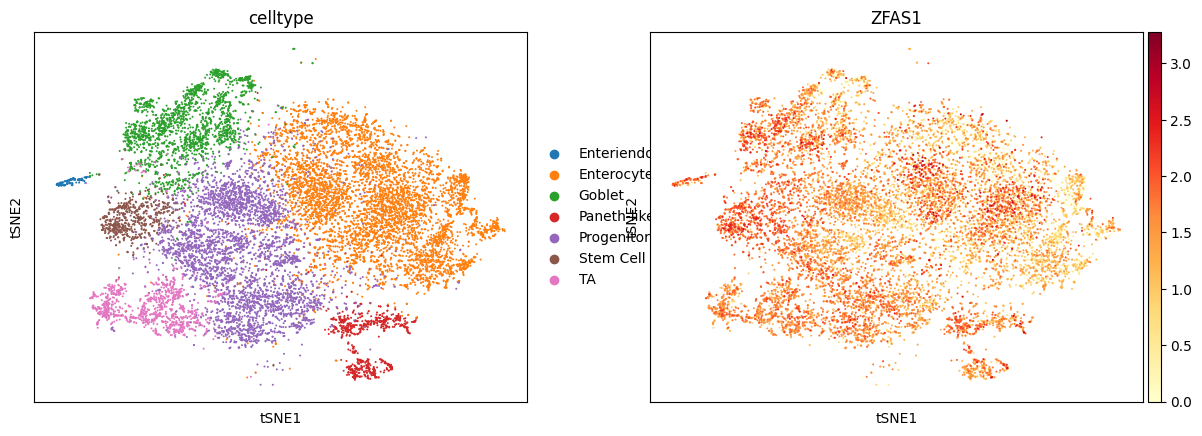

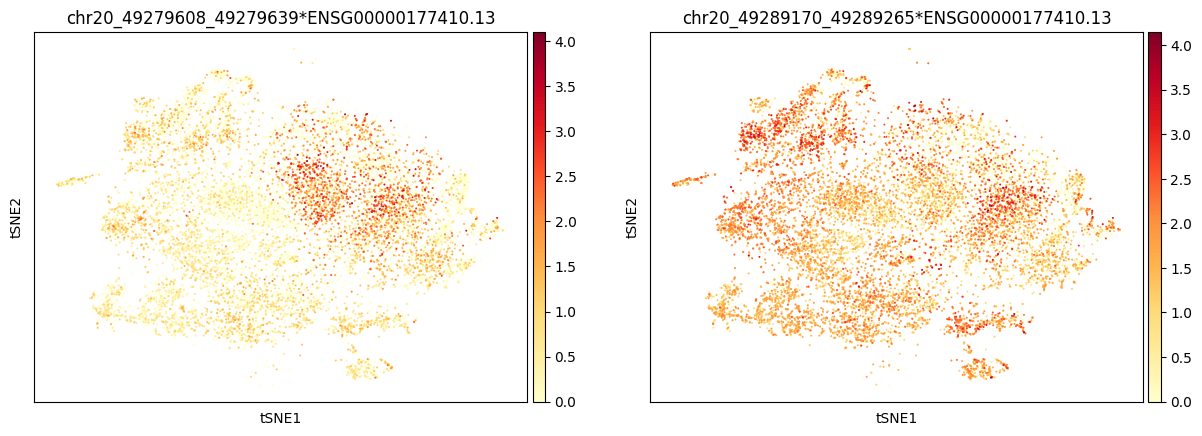

In [64]:

plot_tsne_gene('ZFAS1')

**Valcano plot shows significant differential gene with APA**

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import brie

In [2]:
def plot_valcano(celltype):
    inputfilePath='/mnt/ruiyanhou/nfs_share2/three_primer/human_intestinal/run_BRIE/Brie_out/brie_'+celltype+'.h5ad'
    adata=sc.read(inputfilePath)
    adata.var.index=adata.var['gene_name']
    brie.pl.volcano(adata, y='ELBO_gain', log_y=False, n_anno=5, score_red=3, adjust=True)
    plt.xlabel('cell_coeff: effect size on logit(Psi)')
    plt.title(celltype)
    plt.show()

In [3]:
celltypels=['Enterocyte','Goblet','Progenitor','TA']

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


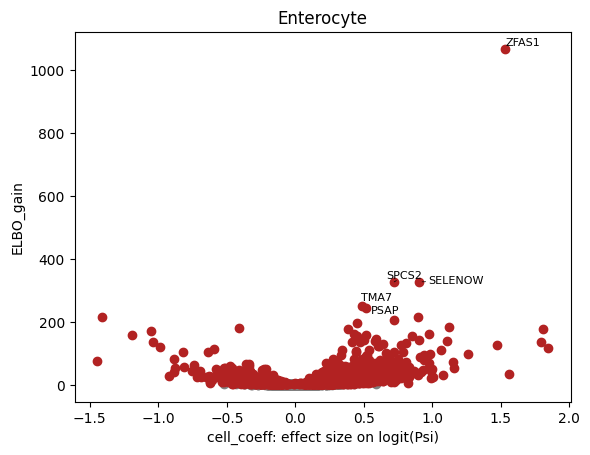

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


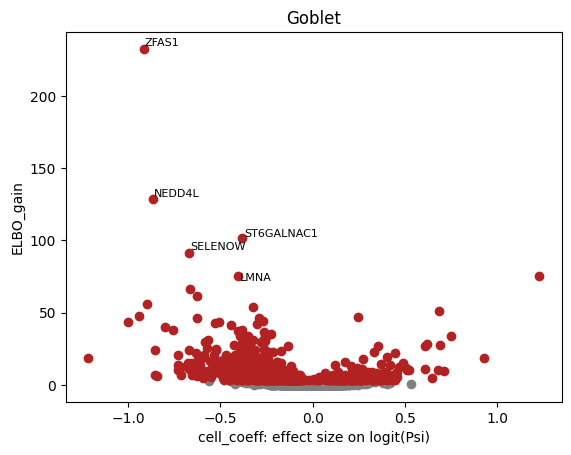

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


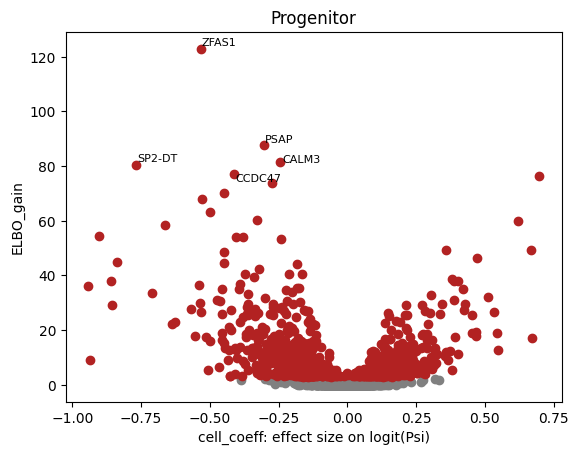

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


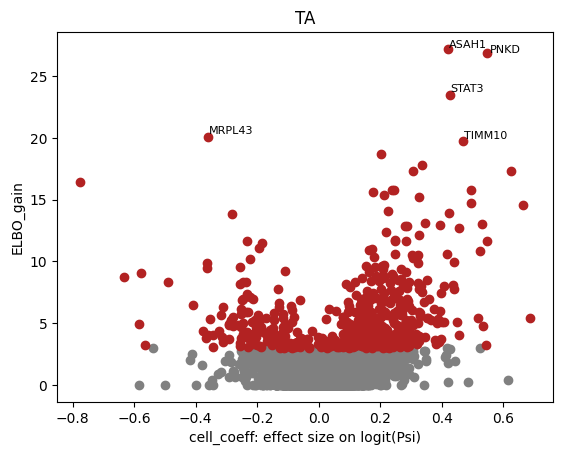

In [4]:
for celltype in celltypels:
    plot_valcano(celltype)
    
    